In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import v_measure_score
from collections import Counter
from sklearn.neighbors import NearestNeighbors



### 1. Read Data

In [3]:
adidas = pd.read_excel("C:\\Users\\ASHISH MAHAJAN\\OneDrive\\Desktop\\BYOP\\Adidas US Sales Datasets.xlsx")

In [4]:
adidas.head(2)

,Retailer,Retailer ID,Invoice Date,Region,State,City,Product,Price per Unit,Units Sold,Total Sales,Operating Profit,Operating Margin,Sales Method
0,Foot Locker,1185732,2020-01-01,Northeast,New York,New York,Men's Street Footwear,50.0,1200,600000.0,300000.0,0.5,In-store
1,Foot Locker,1185732,2020-01-02,Northeast,New York,New York,Men's Athletic Footwear,50.0,1000,500000.0,150000.0,0.3,In-store


### 2. Select numerical features

In [5]:
#select required features
features = ["Price per Unit","Units Sold","Total Sales","Operating Profit","Operating Margin"]

### 3. Drop NAs is any

In [6]:
#drop NA in table
adidas = adidas.dropna(subset=features)

### 4. Create df with relevant features

In [7]:
data = adidas[features].copy()

In [8]:
data

,Price per Unit,Units Sold,Total Sales,Operating Profit,Operating Margin
0,50.0,1200,600000.0,300000.00,0.50
1,50.0,1000,500000.0,150000.00,0.30
2,40.0,1000,400000.0,140000.00,0.35
3,45.0,850,382500.0,133875.00,0.35
4,60.0,900,540000.0,162000.00,0.30
...,...,...,...,...,...
9643,50.0,64,3200.0,896.00,0.28
9644,41.0,105,4305.0,1377.60,0.32
9645,41.0,184,7544.0,2791.28,0.37
9646,42.0,70,2940.0,1234.80,0.42


### 4. Normalize/Standardize features

In [125]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(data)
X

array([[ 0.32529708,  4.4019132 ,  3.57079375,  4.90077985,  0.79233275],
       [ 0.32529708,  3.46838475,  2.86611513,  2.13275705, -1.26544171],
       [-0.3547606 ,  3.46838475,  2.16143651,  1.9482222 , -0.7509981 ],
       ...,
       [-0.28675484, -0.34041132, -0.60411702, -0.5837569 , -0.54522065],
       [-0.21874907, -0.87252254, -0.63656042, -0.61247939, -0.03077704],
       [-1.10282405, -0.81184319, -0.64031636, -0.62327301, -1.57410788]])

### 5. Determine the knee point to find optimal value of Epsilon

5.1 Compute the distance matrix using the NearestNeighbors algorithm
In this process, we first use the NearestNeighbors algorithm to compute the pairwise distances between all points in the data

In [126]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

5.2 Plot the distances in ascending order. Then, we sort the distances in ascending order

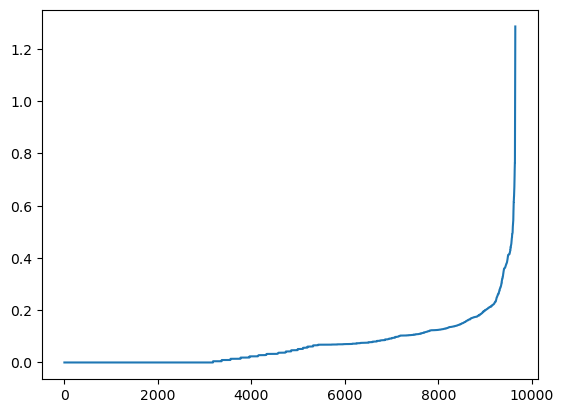

In [127]:
distances = np.sort(distances[:,1])
plt.plot(distances)

5.3 Use the KneeLocator to determine the elbow point in the curve

In [128]:
pip install kneed

Note: you may need to restart the kernel to use updated packages.


In [129]:
from kneed import KneeLocator

kneedle = KneeLocator(range(len(distances)), distances, S=1.0, curve="convex", direction="increasing")
optimal_epsilon = distances[kneedle.knee]
print("Optimal epsilon: ", optimal_epsilon)

Optimal epsilon:  1.2857321992730337


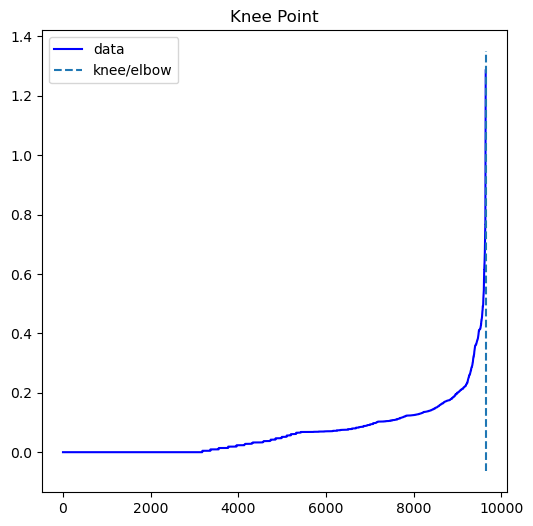

In [130]:
kneedle.plot_knee()
plt.show()

### 6. Determine MinPts

In [131]:
d = 5
min_samples = 2*d

### 7. Apply DBSCAN to cluster the data

In [166]:
dbscan = DBSCAN(eps=0.55, min_samples=10).fit(X)

In [167]:
labels = dbscan.labels_  # or
# labels = dbscan.fit_predict(X)

labels

array([-1,  0,  0, ...,  0,  0,  0], dtype=int64)

### 8. calculate the number of clusters in labels

In [168]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 6
Estimated number of noise points: 373


### 9. evaluate the cluster result with silhouette_score

In [169]:
from sklearn import metrics
print(f"Silhouette Coefficient: {metrics.silhouette_score(X, labels):.3f}")

Silhouette Coefficient: 0.269


### 10.Visualize clustering results with scatter matrix plot 

In [170]:
# add the cluster labels on the result DateFrame
results = data.copy()
results['Clusters'] = dbscan.labels_

results.head()

,Price per Unit,Units Sold,Total Sales,Operating Profit,Operating Margin,Clusters
0,50.0,1200,600000.0,300000.0,0.50,-1
1,50.0,1000,500000.0,150000.0,0.30,0
2,40.0,1000,400000.0,140000.0,0.35,0
3,45.0,850,382500.0,133875.0,0.35,0
4,60.0,900,540000.0,162000.0,0.30,0


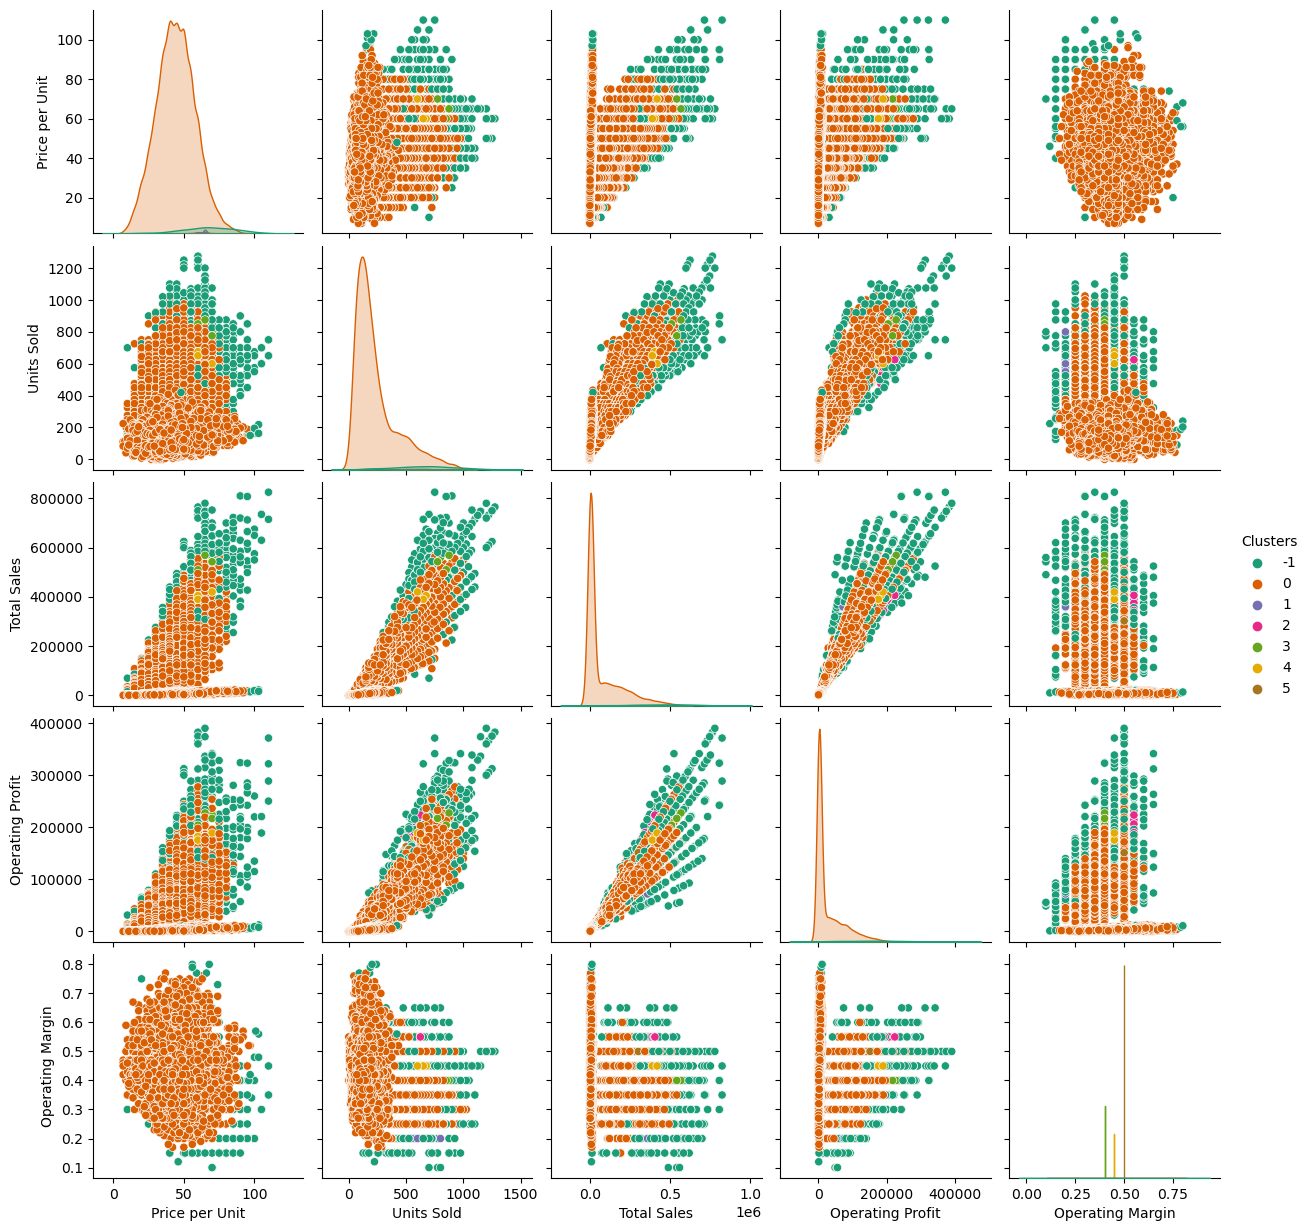

In [171]:
# Create a scatterplot matrix
sns.pairplot(results, hue='Clusters', palette='Dark2')

### 11. investigate the results by averaging the spending on each feature

In [172]:
results_mean = results.groupby(['Clusters']).mean()
results_mean.reset_index(inplace=True)

results_mean

,Clusters,Price per Unit,Units Sold,Total Sales,Operating Profit,Operating Margin
0,-1,67.343164,662.520107,430938.844504,162513.219142,0.392064
1,0,44.201953,238.105914,77622.212263,28431.302844,0.424333
2,1,64.705882,651.470588,421250.000000,84250.000000,0.200000
3,2,63.125000,571.875000,359843.750000,197914.062500,0.550000
4,3,65.000000,837.500000,542916.666667,217166.666667,0.400000
5,4,64.090909,647.727273,413636.363636,186136.363636,0.450000
6,5,60.500000,522.000000,314700.000000,157350.000000,0.500000
